In [80]:
# !pip install segmentation-models-pytorch

In [81]:
import os
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
import gc
import segmentation_models_pytorch as smp

In [129]:
## To clear graph memory
def flush():
  gc.collect()
  torch.cuda.empty_cache()

In [6]:
dataset_dir = os.path.join(os.getcwd(), "data/severstal")
train_img_dir = os.path.join(dataset_dir, "train_images")
print(os.listdir(dataset_dir))

['.~lock.train.csv#', 'train.csv', 'train_images', 'test_images', 'sample_submission.csv']


In [15]:
train_df = pd.read_csv(os.path.join(dataset_dir, "train.csv"))
jpg_files = [filename for filename in os.listdir(train_img_dir) if filename.endswith(".jpg")]

mask = train_df["ImageId"].isin(jpg_files)
train_img_df = train_df[mask].reset_index(drop=True)

train_img_df.head()

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [23]:
train_img_df.loc[0]

ImageId                                              0002cc93b.jpg
ClassId                                                          1
EncodedPixels    29102 12 29346 24 29602 24 29858 24 30114 24 3...
Name: 0, dtype: object

## Create Mask for each Image

In [27]:
def rle_to_mask(rle_string, width, height):
    '''
    Convert RLE(run length encoding) string to a binary mask.
    '''
    rows, cols = height, width
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1, 2)
    img = np.zeros(rows * cols, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1  # RLE is one-based indexing
        img[index:index + length] = 255  # Assigning the mask
    img = img.reshape(cols, rows)
    img = img.T  # Transpose
    return img

In [41]:
images_path = os.path.join(dataset_dir, "images_dir")
masks_path = os.path.join(dataset_dir, "images_masks")

if not os.path.exists(images_path):
    os.makedirs(images_path)
if not os.path.exists(masks_path):
    os.makedirs(masks_path)

In [43]:
for index, row in train_img_df.iterrows():
    img_id, class_id, encoded_pixels = row["ImageId"], row["ClassId"], row["EncodedPixels"]
    
    img_path = os.path.join(train_img_dir, img_id)
    
    with Image.open(img_path) as img:
        width, heigh = img.size
        mask = rle_to_mask(encoded_pixels, width, heigh)
        mask_img = Image.fromarray(mask)
        img.save(os.path.join(images_path, img_id))
        mask_img.save(os.path.join(masks_path, f'{os.path.splitext(img_id)[0]}_mask.png'))
        

In [47]:
images_list = os.listdir(images_path)
masks_list = os.listdir(masks_path)

# sort the images and masks so that each index have the same mask against the image
images_list = sorted(images_list)
masks_list = sorted(masks_list)

# get complete path of images and masks
images_list = [f"{images_path}/{im}" for im in images_list]
masks_list = [f"{masks_path}/{im}" for im in masks_list]

## Show some random Images with there defects mask

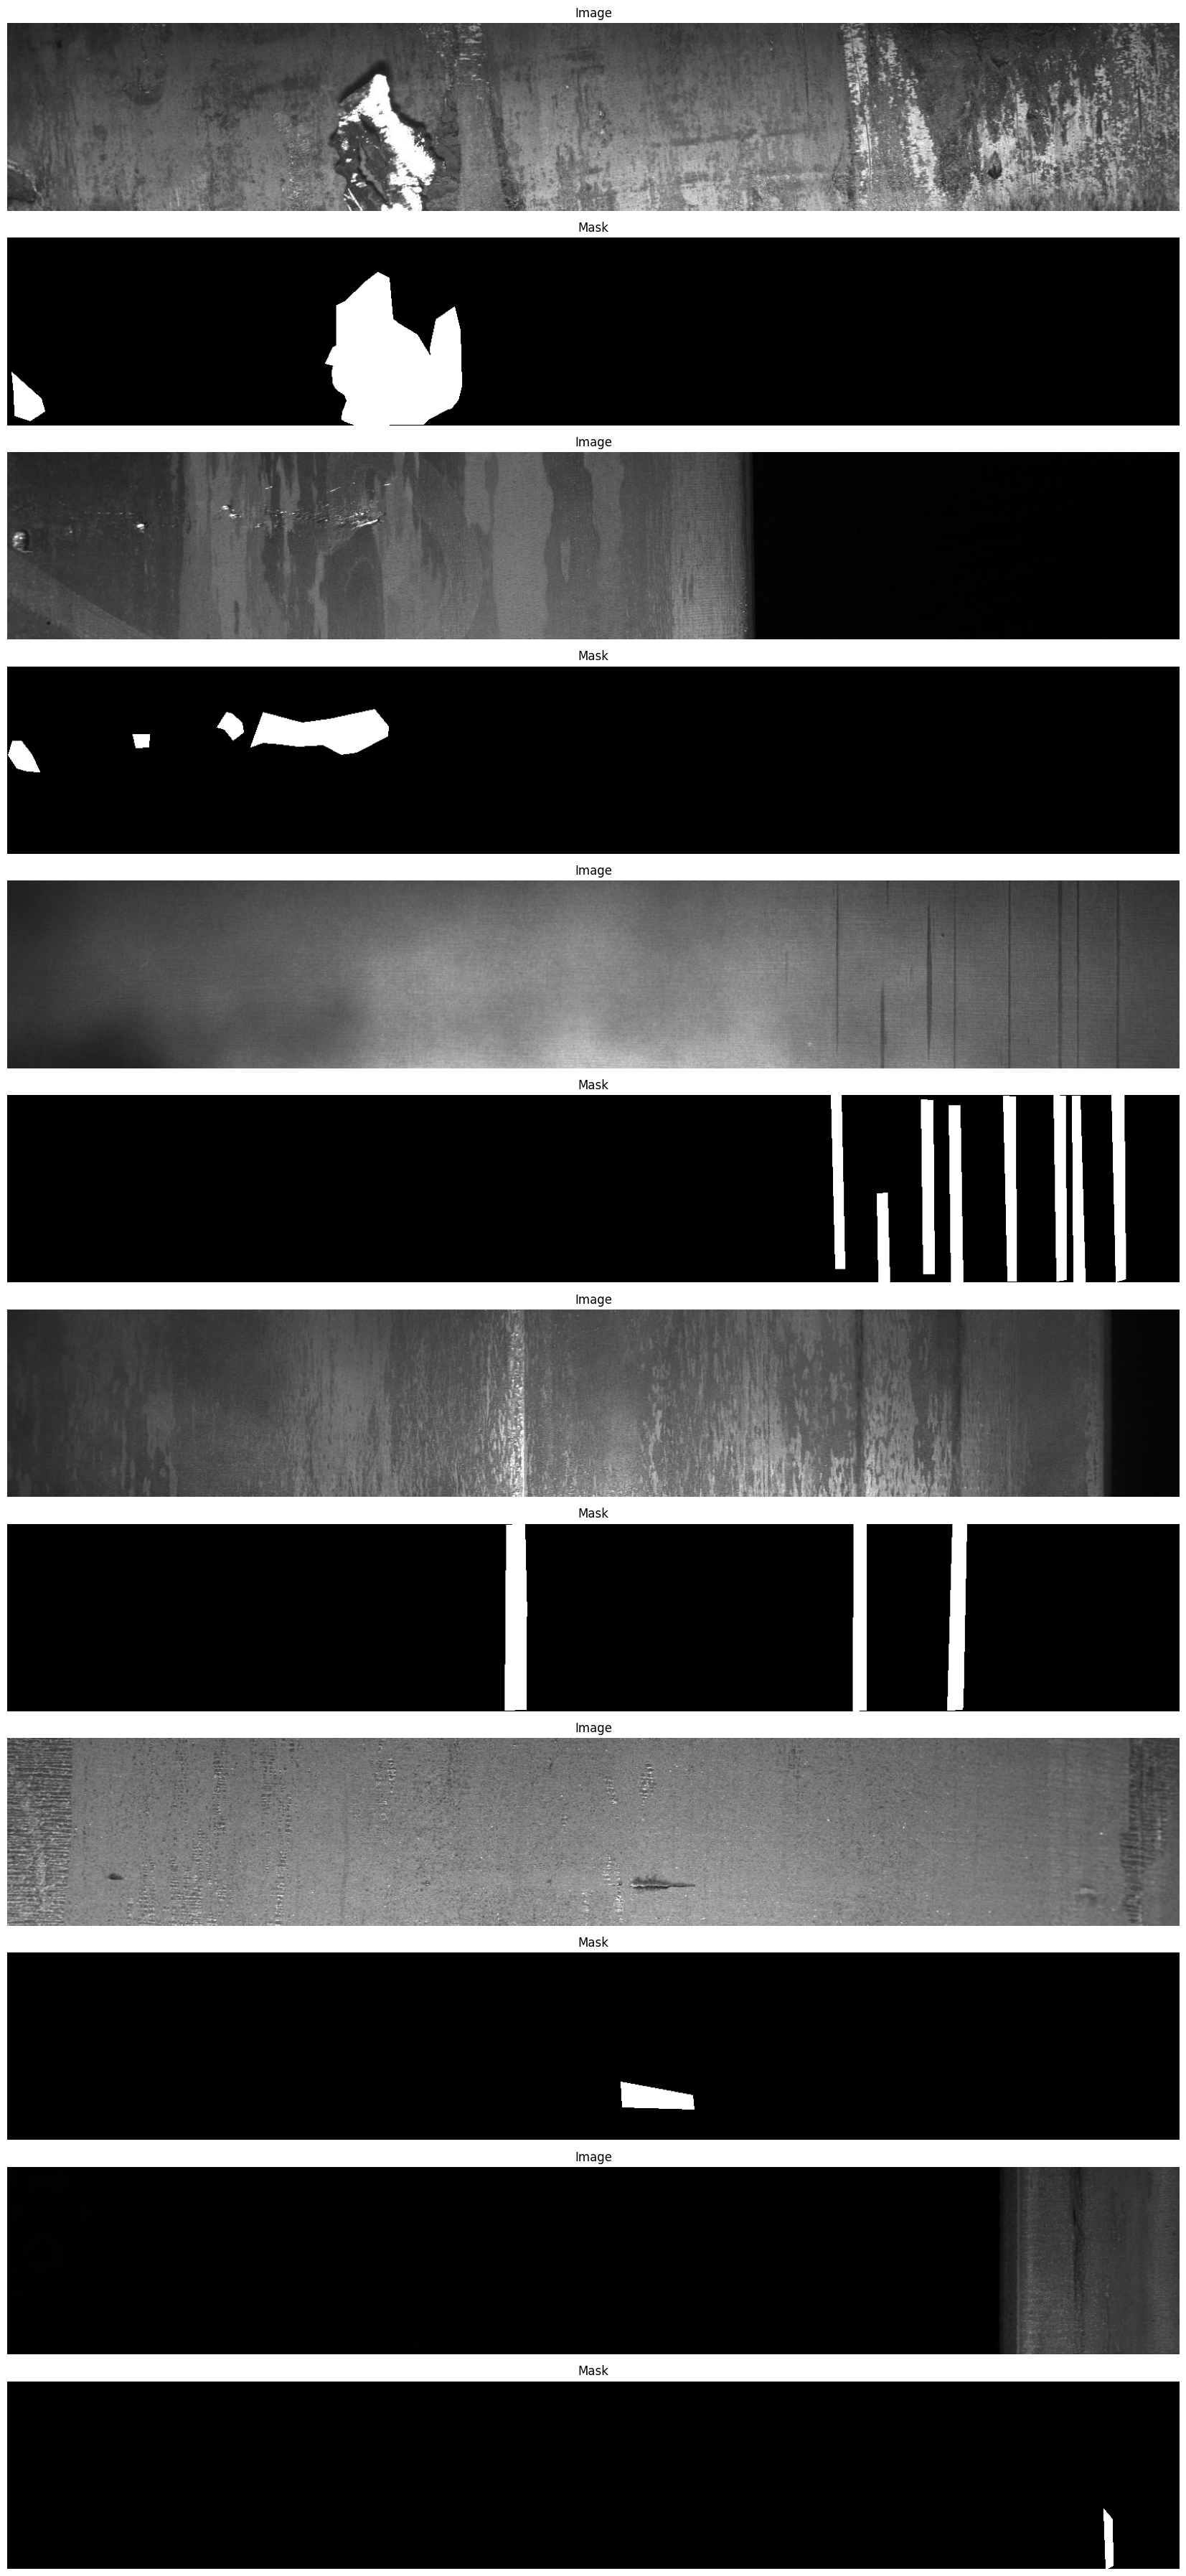

In [144]:
def show_images(img_list, msk_list, num_of_images=6):
    
    if len(img_list) != len(msk_list):
        print(f"images length {len(img_list)} is not equal to masks length {len(msk_list)}")
        return
    
    rand_ids = np.random.randint(0, len(img_list), num_of_images)
    num_rows = num_of_images * 2 
    
    fig = plt.figure(figsize=(40, num_rows * 3))
    for i, index in enumerate(rand_ids):
        image_path, mask_path = img_list[index], msk_list[index]
        img, mask = Image.open(image_path), Image.open(mask_path)
        
        # Adding subplots for the image and mask
        ax_img = fig.add_subplot(num_rows, 1, i*2 + 1)  # Odd subplots for the images
        ax_img.imshow(img)
        ax_img.set_title("Image")
        ax_img.axis("off")
        
        ax_mask = fig.add_subplot(num_rows, 1, i*2 + 2)  
        ax_mask.imshow(mask, cmap="gray")  # Masks are often single-channel, and "gray" colormap is suitable
        ax_mask.set_title("Mask")
        ax_mask.axis("off")
        
    plt.tight_layout()
    plt.show()

show_images(images_list, masks_list, 6)

## Dat Augmentation

In [72]:
train_transform = A.Compose([
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=[0.485, 0.485, 0.485],std=[0.229, 0.229, 0.229],max_pixel_value=255.0),
    ToTensorV2()])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229], max_pixel_value=255.0),
    ToTensorV2()])

# Creat Dataset, Data Loader

In [73]:
class SteelDataset(Dataset):
    def __init__(self, image_list, mask_list, transform =None):
        self.images = image_list
        self.masks = mask_list
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path))
        mask[mask==255.0] = 1.0
        
        if self.transform is not None:
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation['image']
            mask = augmentation['mask']
        
        return image, mask

## Split Images into train, val set

In [74]:
train_images, val_images, train_masks, val_masks = train_test_split(images_list, masks_list, test_size=0.2, random_state=42)

train_dataset = SteelDataset(train_images, train_masks, transform=train_transform)
val_dataset = SteelDataset(val_images, val_masks, transform=val_transform)

## Train Data Loader

In [101]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [75]:
img, mask = train_dataset[5]
img.shape

torch.Size([3, 256, 1600])

In [133]:
IMAGE_WIDTH = 1600
IMAGE_HEIGHT = 256
LEARNING_RATE = 5e-4
BATCH_SIZE = 4
NUM_EPOCHS = 2
N_CLASSES = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
device
flush()

In [134]:
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet",classes=1,activation=None).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# test for errors
x = torch.randn((1, 3, IMAGE_HEIGHT, IMAGE_WIDTH))
x = x.to(device)
pred = model(x)
print(pred.shape)
summary(model=model, input_size=(3, IMAGE_HEIGHT, IMAGE_WIDTH))

torch.Size([1, 1, 256, 1600])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 800]           9,408
       BatchNorm2d-2         [-1, 64, 128, 800]             128
              ReLU-3         [-1, 64, 128, 800]               0
         MaxPool2d-4          [-1, 64, 64, 400]               0
            Conv2d-5          [-1, 64, 64, 400]          36,864
       BatchNorm2d-6          [-1, 64, 64, 400]             128
              ReLU-7          [-1, 64, 64, 400]               0
            Conv2d-8          [-1, 64, 64, 400]          36,864
       BatchNorm2d-9          [-1, 64, 64, 400]             128
             ReLU-10          [-1, 64, 64, 400]               0
       BasicBlock-11          [-1, 64, 64, 400]               0
           Conv2d-12          [-1, 64, 64, 400]          36,864
      BatchNorm2d-13          [-1, 64, 64, 400]             128
         

In [103]:
# Training And Evaluation

In [96]:
# Training Function
def train_one_epoch(model, train_loader, optimizer, loss_func, device):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc='Training')
    
    for batch_idx, (images, targets) in enumerate(train_bar):
        optimizer.zero_grad()
        images = images.to(device)
        targets = targets.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = loss_func(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bar.set_postfix({'loss': f'{train_loss / (batch_idx + 1):.3f}'})
    return train_loss / len(train_loader)

In [97]:
# Validation Loop
def validate(model, test_loader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    val_bar = tqdm(test_loader, desc='Validating')
    with torch.no_grad():
        for images, targets in val_bar:
            images = images.to(device)
            targets = targets.to(device).unsqueeze(1)
            outputs = model(images)
            predicted = torch.sigmoid(outputs)
            predicted = (predicted > 0.5).float()
            total_correct += (predicted == targets).sum().item()
            total_pixels += targets.nelement()
    return total_correct / total_pixels * 100

In [98]:
def plot_results(train_losses, val_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'r-')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, 'b-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()

Epoch 1/3


Training: 100%|█████████████████| 1333/1333 [09:15<00:00,  2.40it/s, loss=0.148]


Training Loss: 0.148


Validating: 100%|█████████████████████████████| 334/334 [00:47<00:00,  7.10it/s]


Validation Accuracy: 96.17%
Epoch 2/3


Training: 100%|█████████████████| 1333/1333 [09:15<00:00,  2.40it/s, loss=0.113]


Training Loss: 0.113


Validating: 100%|█████████████████████████████| 334/334 [00:46<00:00,  7.15it/s]


Validation Accuracy: 96.07%
Epoch 3/3


Training: 100%|█████████████████| 1333/1333 [09:15<00:00,  2.40it/s, loss=0.106]


Training Loss: 0.106


Validating: 100%|█████████████████████████████| 334/334 [00:46<00:00,  7.15it/s]


Validation Accuracy: 96.23%


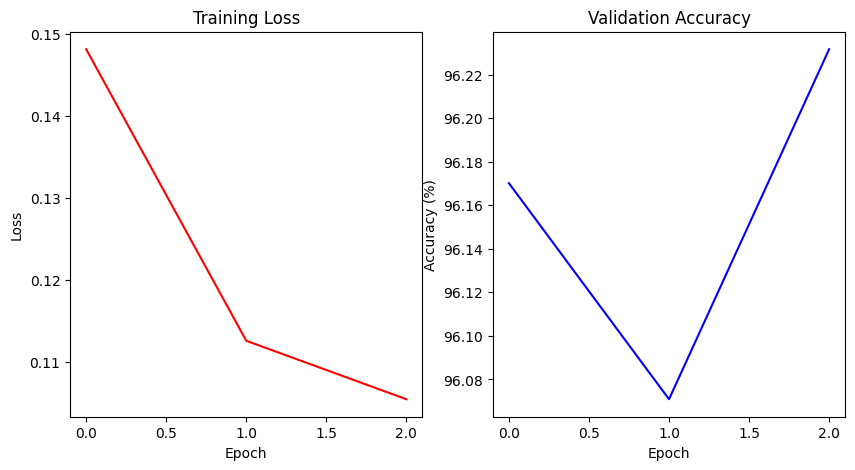

In [135]:
num_epochs = 3
train_losses = []
val_accuracies = []
last_train_loss = 1

for epoch in range(num_epochs ):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    print(f'Training Loss: {train_loss:.3f}')

    accuracy = validate(model, val_loader, device)
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy:.2f}%')
    
    # save check point of the train_loss is low than the previous time
    if train_loss < last_train_loss:
        last_train_loss = train_loss
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        torch.save(checkpoint, "unet_defect_steel.pth.tar")

plot_results(train_losses, val_accuracies)

# make some random predictions / Inference with the trained model

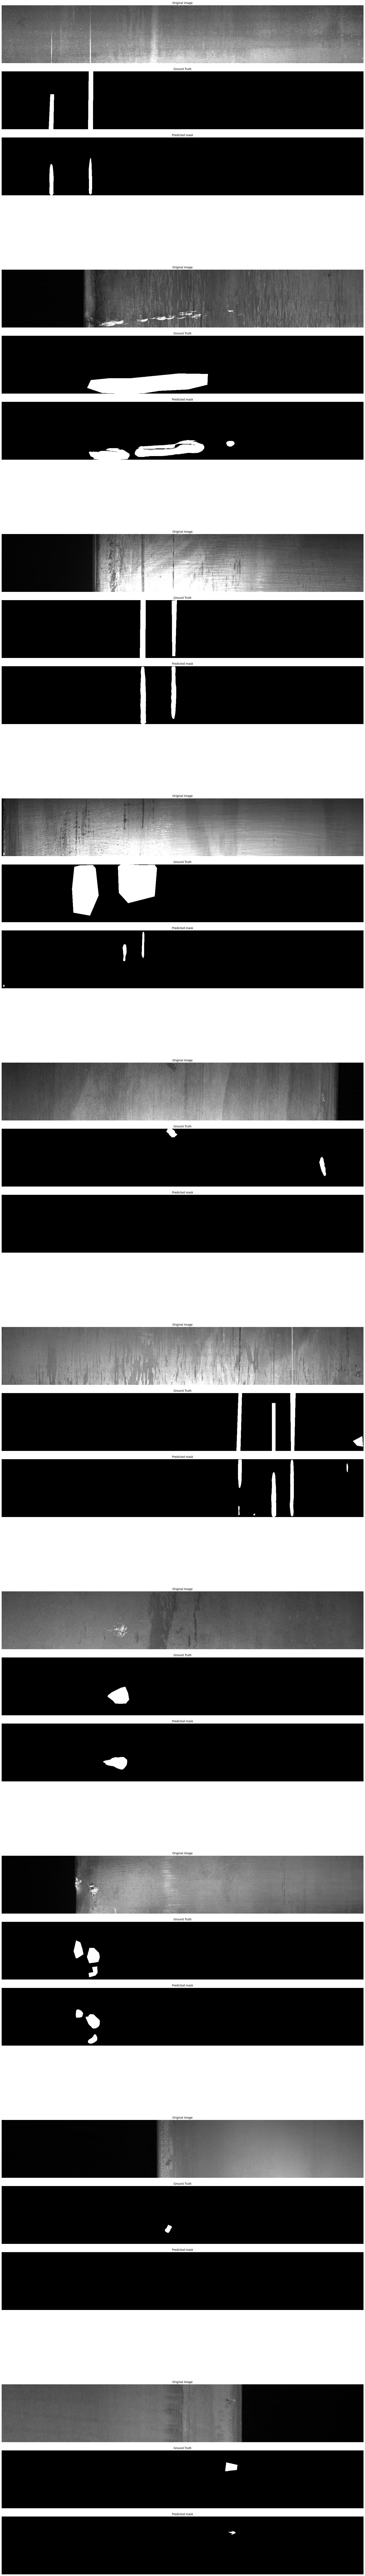

In [142]:
def validate_images(img_list, msk_list, num_of_images = 10, val_transform = val_transform):
    
    if len(img_list) != len(msk_list):
        print(f"images length {len(img_list)} is not equal to masks length {len(msk_list)}")
        return
    
    rand_ids = np.random.randint(1,len(img_list), num_of_images)
    num_rows = num_of_images * 4 
    fig = plt.figure(figsize=(40, num_rows * 4))
    
    model.eval()
    with torch.no_grad():
        for i, index in enumerate(rand_ids):
            image_path, mask_path = img_list[index], msk_list[index]
            img, mask = Image.open(image_path), Image.open(mask_path) 


            ax_img = fig.add_subplot(num_rows, 1, i*4 + 1)  # Odd subplots for the images
            ax_img.imshow(img)
            ax_img.set_title("Original Image")
            ax_img.axis("off")

            ax_ground = fig.add_subplot(num_rows, 1, i*4 + 2)  
            ax_ground.imshow(mask, cmap="gray")  # Masks are often single-channel, and "gray" colormap is suitable
            ax_ground.set_title("Ground Truth")
            ax_ground.axis("off")
            
            transformed_image = val_transform(image = np.array(img), mask = np.array(mask))['image']
            transformed_image = transformed_image.to(device).unsqueeze(0)  
            preds = model(transformed_image)
            preds = (preds > 0.5)
            predicted_map = preds.squeeze().cpu().numpy()
            
            ax_predicted = fig.add_subplot(num_rows, 1, i*4 + 3)  
            ax_predicted.imshow(predicted_map, cmap="gray")  # Masks are often single-channel, and "gray" colormap is suitable
            ax_predicted.set_title("Predicted mask")
            ax_predicted.axis("off")

        plt.tight_layout(h_pad=2)
        plt.show()
        

validate_images(images_list, masks_list, 10, val_transform)     
        